In [1]:
from typing import Callable, Literal, Sequence, NamedTuple

from functools import reduce
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from astropy.time import Time

from lsst.rsp import get_tap_service
import lsst.sphgeom as sph
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_symbols


filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

service = get_tap_service("tap")

# Transients graph

With this notebook we take a slight deviation from what we have been worked on so far. 

We try to build a graph for a subset of the sources in the DP1, in which connected subgraphs represent anomalies from objects at compatible positions.

## Data procesing

### Queryting visits

In [2]:
target_ra, target_dec, target_radius = 53.160, -28.100, 1.000
t1 = Time("2024-12-01T00:00:00.0", format="isot", scale="tai")
t2 = Time("2024-12-11T00:00:00.0", format="isot", scale="tai")

In [22]:
ccdVisit_astropy = service.search(
    f"SELECT * "
    f"FROM dp1.CcdVisit "
    # visit axis lies in target area
    f"WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {target_ra}, {target_dec}, {target_radius}))=1 "
    # filters bands outside selection
    f"AND band IN ('i', 'r', 'g') "
    # sorted by time
    f"ORDER BY obsStartMJD"
).to_table()
ccdVisit_df = ccdVisit_astropy.to_pandas()
ccdVisit_df = ccdVisit_df[(ccdVisit_df["obsStartMJD"] > t1.mjd) & (ccdVisit_df["obsStartMJD"] <= t2.mjd)]
ccdVisit_df = ccdVisit_df.set_index("ccdVisitId")
ccdVisit_df

,astromOffsetMean,astromOffsetStd,band,darkTime,dec,detector,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,...,urcdec,urcra,xSize,ySize,zenithDistance,zeroPoint,visitId,expMidptMJD,expMidpt,obsStartMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
1145204417024,0.011788,0.006040,r,30.4349,-27.832747,0,11.03380,0.307583,1.244190,0.961064,...,-27.934571,53.401083,4071,3999,11.569500,32.031200,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417025,0.006966,0.003864,r,30.4349,-28.066776,1,11.38430,0.319030,1.234830,0.963268,...,-28.168390,53.374600,4071,3999,11.486200,32.032501,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417026,0.006943,0.003595,r,30.4349,-28.301220,2,11.82520,0.329259,1.245600,0.961104,...,-28.403017,53.348294,4071,3999,11.407000,32.031300,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417027,0.010045,0.005640,r,30.4349,-27.809904,3,11.74880,0.327344,1.242060,0.963217,...,-27.911490,53.136337,4071,3999,11.350500,32.032501,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417028,0.007920,0.004600,r,30.4349,-28.043662,4,12.01310,0.335342,1.240090,0.962919,...,-28.145144,53.109517,4071,3999,11.265800,32.032299,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145279958532,0.023663,0.012617,g,30.4393,-28.142454,4,5.63613,0.294995,0.978054,0.651151,...,-28.136665,53.278377,4071,3999,39.152599,31.969900,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017
1145279958533,0.021138,0.009869,g,30.4393,-27.971611,5,5.84377,0.304071,0.984330,0.650814,...,-27.965570,53.461313,4071,3999,39.038601,31.969601,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017
1145279958534,0.022690,0.011321,g,30.4393,-28.474796,6,5.90697,0.307790,0.980730,0.652287,...,-28.469125,53.289107,4071,3999,39.062901,31.970900,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017


### Querying sources

In [23]:
ccdVisit_ids = ccdVisit_df["visitId"].unique()
ccdVisit_ids_str = "(" + ", ".join(map(str, ccdVisit_ids)) + ")"
job = service.submit_job(
    f"SELECT * "
    f"FROM dp1.DiaSource "
    f"WHERE visit IN {ccdVisit_ids_str}"
)
# query is larg-ish, so we launch the job as async
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
diaSource_df = job.fetch_result().to_table().to_pandas()

Job phase is COMPLETED


In [24]:
diaSource_df = job.fetch_result().to_table().to_pandas()

In [25]:
diaSource_df = diaSource_df.set_index("diaSourceId")
# since these are likely statistical error we may multiply them by a number of standard deviations
# we still _not_ sure on how these errors are defined and we should ask on them to be sure that 
# we are not working with excessively large error boxes.
# for the moment i comment this
# NSTD = 3
# diaSource_df[["raErr", "decErr"]] *= NSTD

### Filtering sources

In [26]:
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        len_before, len_before_cols = len(df), len(df.columns)

        df = func(df, *args, *kwargs)
        if (diff := len_before - len(df)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} rows ({100 * float(abs(diff / len_before)):.2f} %, originally: {len_before})")
        if (diff := len_before_cols - len(df.columns)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} columns (originally: {len_before_cols})")
        return df
    return msg_wrapper


flag_columns = [
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "centroid_flag",
    "apFlux_flag",
    "isDipole",
    # next flags are from Liu 2024
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_offimage",
    "pixelFlags_bad",
    "psfFlux_flag",
    "shape_flag",
]

def filter_flags(df: pd.DataFrame, flag_columns: list[str]) -> pd.DataFrame:
    for flag in flag_columns:
        def filter_func(df: pd.DataFrame, flag_name: str = flag) -> pd.DataFrame:
            return df[~df[flag_name]]
        
        filter_func.__name__ = f"filter_{flag}"
        df = verbose(filter_func)(df)
    return df
    

@verbose
def filter_nans(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(subset=["ra", "dec", "raErr", "decErr"])


# diaSource_df = filter_nans(filter_flags(diaSource_df))
diaSource_df = filter_nans(filter_flags(diaSource_df, flag_columns))

filter_pixelFlags_cr cut 898 rows (0.49 %, originally: 183890)
filter_centroid_flag cut 32469 rows (17.74 %, originally: 182992)
filter_apFlux_flag cut 52 rows (0.03 %, originally: 150523)
filter_isDipole cut 68781 rows (45.71 %, originally: 150471)
filter_pixelFlags_saturated cut 2044 rows (2.50 %, originally: 81690)
filter_pixelFlags_suspect cut 166 rows (0.21 %, originally: 79646)
filter_pixelFlags_streak cut 741 rows (0.93 %, originally: 79480)
filter_shape_flag cut 23801 rows (30.23 %, originally: 78739)
filter_nans cut 41 rows (0.07 %, originally: 54938)


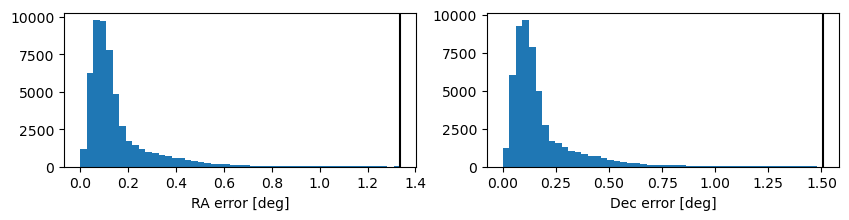

The 99.0-percentile RA error is 1.34 arcsec
The 99.0-percentile dec error is 1.51 arcsec


In [27]:
q = 0.99

fig, axs = plt.subplots(1,2, figsize=(10, 2))
_  = axs[0].hist(_raErrs_arcsec := diaSource_df["raErr"] * 3600, bins=np.linspace(0, np.quantile(_raErrs_arcsec, 0.99), 50))
axs[0].axvline(np.quantile(_raErrs_arcsec, q), color="k")
axs[0].set_xlabel("RA error [deg]")
_  = axs[1].hist(_decErrs_arcsec := diaSource_df["decErr"] * 3600, bins=np.linspace(0, np.quantile(_decErrs_arcsec, 0.99), 50))
axs[1].axvline(np.quantile(_decErrs_arcsec, q), color="k")
axs[1].set_xlabel("Dec error [deg]")
plt.show()

print(f"The {100 * q}-percentile RA error is {np.quantile(_raErrs_arcsec, q):.2f} arcsec")
print(f"The {100 * q}-percentile dec error is {np.quantile(_decErrs_arcsec, q):.2f} arcsec")

In [28]:
@verbose
def filter_coorderr(df: pd.DataFrame, quantile: float)  -> pd.DataFrame:
    return df[
        (df["raErr"] < np.quantile(df["raErr"], quantile)) &
        (df["decErr"] < np.quantile(df["decErr"], quantile))
    ]

diaSource_df = filter_coorderr(diaSource_df, 0.99)

filter_coorderr cut 760 rows (1.38 %, originally: 54897)


### Data utilities

In [29]:
def _map_source2ccdVisit(diaSources: pd.DataFrame, ccdVisits: pd.DataFrame) -> Callable:
    visit_lookup = {
       (row['visitId'], row['detector']): idx 
       for idx, row in ccdVisits.iterrows()
    }
    sources_lookup = pd.Series({
       idx: visit_lookup.get((row['visit'], row['detector']))
       for idx, row in diaSources.iterrows()
    })
    
    def helper(source_index: pd.Index | int) -> pd.Series | int:
        return sources_lookup[source_index]
    return helper

    
def _source_region(diaSources: pd.DataFrame) -> Callable:
    region_lookup = {
        # source_index: sph.Box(
        #     center=sph.LonLat.fromDegrees(source["ra"], source["dec"]),
        #     # we divide by two because the constructor takes half-width and half-height
        #     # http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1sphgeom_1_1_box.html
        #     width=sph.Angle.fromDegrees(nstd * source["raErr"]) / 2,
        #     height=sph.Angle.fromDegrees(nstd * source["decErr"]) / 2,
        # )
        source_index: sph.Circle(
            center=sph.UnitVector3d(sph.LonLat.fromDegrees(source["ra"], source["dec"])),
            angle=sph.Angle.fromDegrees(np.sqrt(source["raErr"] ** 2 + source["decErr"] ** 2)),
        )
        for source_index, source in diaSources.iterrows()
    }

    def helper(source_index: int) -> sph.Region:
        return region_lookup[source_index]
    return helper


def _source_time(ccdVisits: pd.DataFrame, diaSources: pd.DataFrame, s2v: Callable) -> Callable:
    index = diaSources.index.to_series().map(s2v).map(ccdVisits["obsStartMJD"])
    
    def helper(source_index:  pd.Index | int) -> pd.Series | float:
        return index[source_index]
    return helper


def _source_band(ccdVisits: pd.DataFrame, diaSources: pd.DataFrame, s2v: Callable) -> Callable:
    index = diaSources.index.to_series().map(s2v).map(ccdVisits["band"])
    
    def helper(source_index:  pd.Index | int) -> pd.Series | Literal["u", "g", "r", "i", "z", "y"]:
        return index[source_index]
    return helper


print("indexing visits..")
source_visit: Callable = _map_source2ccdVisit(diaSource_df, ccdVisit_df)
print("indexing regions..")
source_region: Callable = _source_region(diaSource_df)
print("indexing source observation times..")
source_time: Callable = _source_time(ccdVisit_df, diaSource_df, source_visit)
print("indexing source visit bands..")
source_band: Callable = _source_band(ccdVisit_df, diaSource_df, source_visit)

indexing visits..
indexing regions..
indexing source observation times..
indexing source visit bands..


### Sorting sources

In [30]:
diaSource_df = diaSource_df.sort_index(key=source_time)

# KD-Tree indexing

We use a KD-tree for spatial indexing the diaSources in our dataset. The index is used for searching compatible (close) sources. It supports two methods:

1. a radius search `search_radius`
2. a neighbour search `search_close`. This methods calls `search_radius` under the hood with a "large" radius relative to the dataset astrometric errors, then it filters neighbour candidates checking overlaps in their bouding regions.

In [31]:
def _sph2xyz(
    lons: np.array, 
    lats: np.array, 
) -> np.array:
    """
    Converts from spherical coordinates (in degrees) to cartesian over the unit sphere.
    """
    lons = np.deg2rad(lons)
    lats = np.deg2rad(lats)

    x = (cos_lat_rad := np.cos(lats)) * np.cos(lons)
    y = cos_lat_rad * np.sin(lons)
    z = np.sin(lats)
    return np.column_stack([x, y, z])


class SourceTree:
    def __init__(self, diaSources: pd.DataFrame, s2region: Callable):
        self.diaSources = diaSources
        self.s2region = s2region
        self.tree = KDTree(_sph2xyz(diaSources["ra"], diaSources["dec"]))
        # chosen so that `search_close` contains id1 and id2, if id1 and id2 are the call's arguments
        # and id1, id2 are the sources with the largest astrometric error in the dataset.
        # on the factor 2: two circles of radius r touching at their edges are separated by 2r center-to-center.
        self._radius = 2 * np.sqrt(diaSources['raErr'].max() ** 2 + diaSources['decErr'].max() ** 2)
        
    def search_radius(
        self,
        ra: float,
        dec: float,
        radius: float,
    ) -> pd.Index:
        """
        Returns all diaSources within a circle of radius `radius` centered at (`ra`, `dec`).
        All inputs are assumed in degrees.
        """
        center_xyz = _sph2xyz(ra, dec).reshape(-1)
        idxs = self.tree.query_ball_point(center_xyz, r=np.deg2rad(radius))
        return self.diaSources.index[idxs]
    
    def search_close(
        self,
        source_index: int,
        drop: bool = True,
    ) -> list:
        ra, dec = self.diaSources .loc[source_index][["ra", "dec"]]
        candidate_ids = self.search_radius(ra, dec, self._radius)
        if drop:
            candidate_ids = candidate_ids.drop([source_index])
        source_region = self.s2region(source_index)
        return [*filter(lambda idx: self.s2region(idx).overlaps(source_region), candidate_ids)]


st = SourceTree(diaSource_df, source_region)

# a basic test
assert (_idx := diaSource_df.index[0]) in st.search_radius(*diaSource_df.loc[_idx][["ra", "dec"]], 1/36000)
assert (_idx := diaSource_df.index[0]) in st.search_close(_idx, drop=False)

# Graph building

In [32]:
def tree2graph(tree: SourceTree, s2time: Callable) -> nx.DiGraph:
    from tqdm.notebook import tqdm
    
    G = nx.DiGraph()
    stimes = s2time(tree.diaSources.index)
    for diaSources_index, diaSource in tqdm(tree.diaSources.iterrows(), total=len(tree.diaSources), desc="Building graph"):
        source_time = s2time(diaSources_index)
        for match_index in tree.search_close(diaSources_index):
            if source_time < (match_time := stimes.loc[match_index]):
                G.add_edge(diaSources_index, match_index)
                G.nodes[diaSources_index]["obsStartMJD"] = source_time
                G.nodes[match_index]["obsStartMJD"] = match_time
                
    TR = nx.transitive_reduction(G)
    TR.add_nodes_from(G.nodes(data=True))
    TR.add_edges_from((u, v, G.edges[u, v]) for u, v in TR.edges)
    return TR


graph = tree2graph(st, source_time)

Building graph:   0%|          | 0/54137 [00:00<?, ?it/s]

In [33]:
def graph2components(graph: nx.DiGraph, minsize: int = 1) -> list[list]:
    return [*filter(
        # remove weak components shorter than minsize
        lambda xs: len(xs) >= minsize, 
        # transforms set to list and sort sources by time
        map(
            lambda xs: sorted([*xs], key=lambda x: graph.nodes[x]["obsStartMJD"]), 
            nx.weakly_connected_components(graph)),
    )]


wcomps = graph2components(graph, minsize=2)
print(f"Found {len(wcomps)} weakly connected graph components.")

Found 4079 weakly connected graph components.


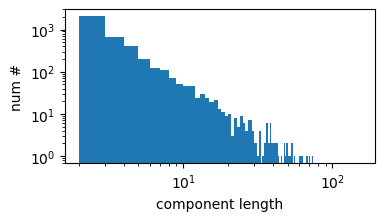

In [34]:
fig, _ = plt.subplots(1,1, figsize=(4, 2))
plt.hist(_wcomp_len := [*map(len, wcomps)], bins=np.arange(2, max(_wcomp_len), 1))
plt.xlabel("component length"); plt.ylabel("num #"); plt.loglog()
plt.show()

# Catalog associations

In [35]:
class Association(NamedTuple):
    id: str
    otype: str
    ra: float
    dec: float
    distance: float


def match_to_simbad(
    ras: Sequence[float],
    decs: Sequence[float],
    radiuses: Sequence[float],
    batch_size: int = 500,
    fields: tuple[str] = ("otype",),
) -> list[Association | None]:    
    from astropy.coordinates import SkyCoord
    from astropy.coordinates import match_coordinates_sky
    from astropy.table import Table
    from astropy.table import vstack
    from astropy import units as u
    from astroquery.simbad import Simbad
    from tqdm.notebook import tqdm

    
    def simbad_query(
        ras: Sequence[float],
        decs: Sequence[float],
        radiuses: Sequence[float],
        batch_size: int,
        fields: tuple[str] = ("otype",),
    ) -> Table:
        if not len(ras) == len(decs) == len(radiuses):
            raise ValueError("Query ra, declinations and radiuses must have same length.")
            
        simbad = Simbad()
        
        for field in fields:
            simbad.add_votable_fields(field)
        batch_results = []
        for i in tqdm(range(0, len(ras), batch_size), desc="Querying simbad"):
            s = slice(i, i + batch_size)
            result = simbad.query_region(
                SkyCoord(
                    ra = [ra * u.deg for ra in ras[s]],
                    dec = [dec * u.deg for dec in decs[s]],
                ),
                radius = [r * u.deg for r in radiuses[s]]
            )
            if result is not None:
                batch_results.append(result)
        return vstack(batch_results, metadata_conflicts="silent")

    
    simbad_objects = simbad_query(ras, decs, radiuses, batch_size=batch_size, fields=fields)
    ids, d2d, _ = match_coordinates_sky(
        SkyCoord(
            ra = [ra * u.deg for ra in ras],
            dec = [dec * u.deg for dec in decs],
        ),
        SkyCoord(
            ra = simbad_objects["ra"],
            dec = simbad_objects["dec"],
        ),
    )
    simbad_ra_deg = [*map(float, simbad_objects["ra"].to(u.deg).to_value())]
    simbad_dec_deg = [*map(float, simbad_objects["dec"].to(u.deg).to_value())]
    d2d_deg = [*map(float, d2d.to(u.deg).to_value())]
    return [
        Association(
            *simbad_objects[simbad_id := ids[i]][["main_id", "otype"]], 
            simbad_ra_deg[simbad_id],
            simbad_dec_deg[simbad_id],
            d2d_deg[i],
        )
        if d2d_deg[i] < radiuses[i] else None
        for i in range(len(ids))
    ]

def comps2circles(comps, s2r: Callable) -> list[sph.Circle]:
    """
    Compute minimal bounding circle for each component.
    Uses reduce to iteratively expand circles to encompass all sources.
    """
    return  [
        reduce(
            lambda x, y: x.expandTo(y), 
            map(lambda x: s2r(x), cs),
            # this will avoid die out on lists with one element
            # it works since .expandTo() is idempotent
            s2r(cs[0]),
        )
        for cs in comps
    ]


def circles2associations(circles: Sequence[sph.Circle], rmin: float=0.) -> list[Association | None]:
    centers = [sph.LonLat(c.getCenter()) for c in circles]
    radiuses = np.clip([c.getOpeningAngle().asDegrees() for c in circles], a_min=rmin, a_max=None)
    ras = [c.getLon().asDegrees() for c in centers]
    decs = [c.getLat().asDegrees() for c in centers]
    return match_to_simbad(ras, decs, radiuses)



RMIN = 0.5 / 3600  # lsst pixel scale
associations = circles2associations(comps2circles(wcomps, source_region), rmin=RMIN)
print(f"fraction of non-null association is {100 * len([*filter(lambda x: x is not None, associations)]) / len(associations):.2f} %")

Querying simbad:   0%|          | 0/9 [00:00<?, ?it/s]

fraction of non-null association is 13.70 %


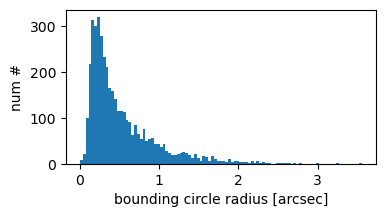

In [36]:
radii_arcsec = np.array([c.getOpeningAngle().asDegrees() for c in comps2circles(wcomps, source_region)]) * 3600

fig, _ = plt.subplots(1,1, figsize=(4, 2))
_ = plt.hist(radii_arcsec, bins=np.linspace(0, radii_arcsec.max(), 100))
plt.xlabel("bounding circle radius [arcsec]"); plt.ylabel("num #")
plt.show()

### Control sample: associations against random sources

In [37]:
def test_random_associations(circles: Sequence[sph.Circle], target_ra: float, target_dec: float, target_radius: float, rmin: float=0.) -> list[Association | None]:
    radiuses = [max(c.getOpeningAngle().asDegrees(), rmin) for c in circles]
    ras = np.random.rand(len(circles)) * target_radius + (target_ra - target_radius / 2)
    decs = np.random.rand(len(circles)) * target_radius + (target_dec - target_radius / 2)
    return match_to_simbad(ras, decs, radiuses)


random_associations = test_random_associations(comps2circles(wcomps, source_region), target_ra, target_dec, target_radius, RMIN)
print(f"fraction of non-null association is {100 * len([*filter(lambda x: x is not None, random_associations)]) / len(random_associations):.2f} %")

Querying simbad:   0%|          | 0/9 [00:00<?, ?it/s]

fraction of non-null association is 0.5883795047805834 %
